In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
df=pd.read_csv("top_40.csv")
df

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,...,is_max_3,is_max_6,is_max_12,is_max_24,is_max_36,año,mes,cuatrimestre,mes_absoluto,cos_mes
0,10004,20001,2017-01-01,0.0,9.0,184.72927,184.72927,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
1,10003,20001,2017-01-01,0.0,17.0,143.49426,143.49426,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
2,10002,20001,2017-01-01,0.0,17.0,38.68301,35.72806,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
3,10001,20001,2017-01-01,0.0,11.0,99.43861,99.43861,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
4,10084,20001,2017-01-01,0.0,1.0,0.22386,0.22386,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360751,10573,20024,2019-12-01,0.0,0.0,0.00000,0.00000,2.65356,1,10,...,1,1,0,0,0,2019,12,3,35,1.000000
360752,10579,20024,2019-12-01,0.0,0.0,0.00000,0.00000,2.65356,1,10,...,1,1,0,0,0,2019,12,3,35,1.000000
360753,10584,20024,2019-12-01,0.0,0.0,0.00000,0.00000,2.65356,1,10,...,1,1,0,0,0,2019,12,3,35,1.000000
360754,10503,20024,2019-12-01,0.0,0.0,0.00000,0.00000,2.65356,1,10,...,1,1,0,0,0,2019,12,3,35,1.000000


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar y preparar datos
df = pd.read_csv("top_40.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear features adicionales

# 3.1 Promedio histórico de febreros
febreros = df_prod[df_prod['periodo'].dt.month == 2]
febrero_hist = febreros[febreros['periodo'].dt.year < 2020].groupby('product_id')['tn'].mean().reset_index()
febrero_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 3.2 Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 4. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 5. Calcular deltas
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 6. Preparar entrenamiento y validación
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes', 'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

# 6.1 Clip de seguridad para evitar overflows al aplicar log1p / expm1
max_tn_log = 1e8  # podés ajustar según tu dominio
train_data[target] = train_data[target].clip(upper=max_tn_log)
val_data[target] = val_data[target].clip(upper=max_tn_log)

# 6.2 Preparar features y target transformado
X_train = train_data[features]
y_train = np.log1p(train_data[target])  # log-transformado
X_val = val_data[features]
y_val = np.log1p(val_data[target])      # log-transformado

# 7. Entrenar modelo
mejores_params = {
    'n_estimators': 695,
    'learning_rate': 0.016012820789565715,
    'max_depth': 15,
    'num_leaves': 225,
    'min_data_in_leaf': 38,
    'min_child_weight': 7.464229394708427,
    'subsample': 0.7241008897428671,
    'subsample_freq': 3,
    'colsample_bytree': 0.8193227369441615,
    'colsample_bynode': 0.6445006852158011,
    'reg_alpha': 3.156950565147241,
    'reg_lambda': 4.5642326238576825,
    'max_bin': 176,
    'min_split_gain': 0.29357458987785395,
    'cat_smooth': 68.22204283965468,
    'random_state': 42,
    'verbosity': -1,
    'linear_tree': True
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 8. Validación
y_pred_val = np.expm1(modelo.predict(X_val))
print("📊 MAE en diciembre 2019:", mean_absolute_error(np.expm1(y_val), y_pred_val))

# 9. Predicción enero 2020
enero_df = df_prod[df_prod['periodo'] == '2019-12-01'].copy()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['lag_1'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
enero_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
enero_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-10-01']['tn'].values
enero_df['mes'] = 1
enero_df['media_movil_12m'] = df_prod[df_prod['periodo'] == '2019-12-01']['media_movil_12m'].values
enero_df['var_lag1_lag2'] = enero_df['lag_1'] / enero_df['lag_2']
enero_df['delta_lag1_lag2'] = enero_df['lag_1'] - enero_df['lag_2']
enero_df['delta_rel_lag1_lag2'] = enero_df['delta_lag1_lag2'] / enero_df['lag_2']
enero_df['delta_ma12_lag1'] = enero_df['lag_1'] - enero_df['media_movil_12m']
enero_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

enero_df['tn'] = np.expm1(modelo.predict(enero_df[features])).clip(lower=0)

# 10. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['lag_1'] = enero_df['tn']
feb_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
feb_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
feb_df['mes'] = 2
feb_df['media_movil_12m'] = df_prod[df_prod['periodo'] == '2019-12-01']['media_movil_12m'].values
feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 11. Merge con febrero histórico
feb_df = feb_df.merge(febrero_hist, on='product_id', how='left')

# 12. Predicción en febrero con ajuste log→real
pred_log = modelo.predict(feb_df[features])
feb_df['tn_predicho'] = np.expm1(pred_log).clip(lower=0)

# 13. Ajuste con promedio histórico de febreros
feb_df['tn_predicho_ajustada'] = (0.6 * feb_df['tn_predicho'] + 0.4 * feb_df['febrero_hist']).clip(lower=0)

# 14. Eliminar NaNs
feb_df = feb_df.dropna(subset=['product_id', 'tn_predicho_ajustada'])

# 15. Rango histórico real por product_id
rango_historico = df_prod.groupby('product_id')['tn'].agg(['min', 'max']).reset_index()
rango_historico.columns = ['product_id', 'tn_min', 'tn_max']

# 16. Clip por rango
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado = resultado.merge(rango_historico, on='product_id', how='left')
resultado['tn_predicho'] = resultado['tn_predicho'].clip(lower=resultado['tn_min'], upper=resultado['tn_max'])

# 17. Validación de integridad
product_ids_esperados = set(df['product_id'].unique())
product_ids_obtenidos = set(resultado['product_id'].unique())
faltantes = product_ids_esperados - product_ids_obtenidos
assert len(faltantes) == 0, f"❌ Faltan predicciones para {len(faltantes)} product_id(s): {sorted(faltantes)}"

# 18. Exportar
resultado = resultado[['product_id', 'tn_predicho']]
resultado.to_csv("prediccion_feb2020_top40_nuevo.csv", index=False)
print("✅ Predicción febrero 2020 guardada correctamente")


C:\Users\waldo\AppData\Local\Temp\ipykernel_4688\339952060.py:87: RuntimeWarning: overflow encountered in expm1
  y_pred_val = np.expm1(modelo.predict(X_val))


ValueError: Input contains infinity or a value too large for dtype('float64').

In [5]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top40nuevo.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_40.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo             tn
1  2017-02-01   10414.562270
2  2017-03-01   14360.257460
3  2017-04-01   12495.123440
4  2017-05-01   14867.309850
5  2017-06-01   14365.538740
6  2017-07-01   13124.215230
7  2017-08-01   14592.670290
8  2017-09-01   17528.125200
9  2017-10-01   17999.233710
10 2017-11-01   14961.253380
11 2017-12-01   12500.909020
12 2018-01-01   10131.945400
13 2018-02-01   11245.160940
14 2018-03-01   14930.808840
15 2018-04-01   11746.679490
16 2018-05-01   12900.034470
17 2018-06-01   11247.895820
18 2018-07-01   11228.336050
19 2018-08-01   13380.396380
20 2018-09-01   11416.147900
21 2018-10-01   13908.308900
22 2018-11-01   12885.855050
23 2018-12-01   10159.442040
24 2019-01-01   10589.115960
25 2019-02-01    9909.840890
26 2019-03-01   11475.244060
27 2019-04-01   11667.192040
28 2019-05-01   11385.048680
29 2019-06-01   11377.759700
30 2019-07-01   11965.831900
31 2019-08-01    8142.772430
32 2

In [6]:
# Top 10 predicciones más altas
resultado.sort_values('tn_predicho', ascending=False).head(10)


,product_id,tn_predicho
13,20014,115683.004516
7,20008,96494.618061
12,20013,68575.757197
18,20019,37311.238900
8,20009,19219.014297
10,20011,7887.076775
14,20015,3300.462551
22,20024,2238.024111
19,20020,1094.780487
15,20016,899.121794


In [7]:
# Toneladas totales por producto predicho
resultado.groupby('product_id')['tn_predicho'].sum().sort_values(ascending=False).head(10)


product_id
20014    115683.004516
20008     96494.618061
20013     68575.757197
20019     37311.238900
20009     19219.014297
20011      7887.076775
20015      3300.462551
20024      2238.024111
20020      1094.780487
20016       899.121794
Name: tn_predicho, dtype: float64


📌 Importancia de variables:
               feature  importancia
4      media_movil_12m         1518
0                lag_1         1433
3                  mes         1159
2                lag_3         1078
8      delta_ma12_lag1         1060
6      delta_lag1_lag2          989
1                lag_2          757
5        var_lag1_lag2          712
7  delta_rel_lag1_lag2          127


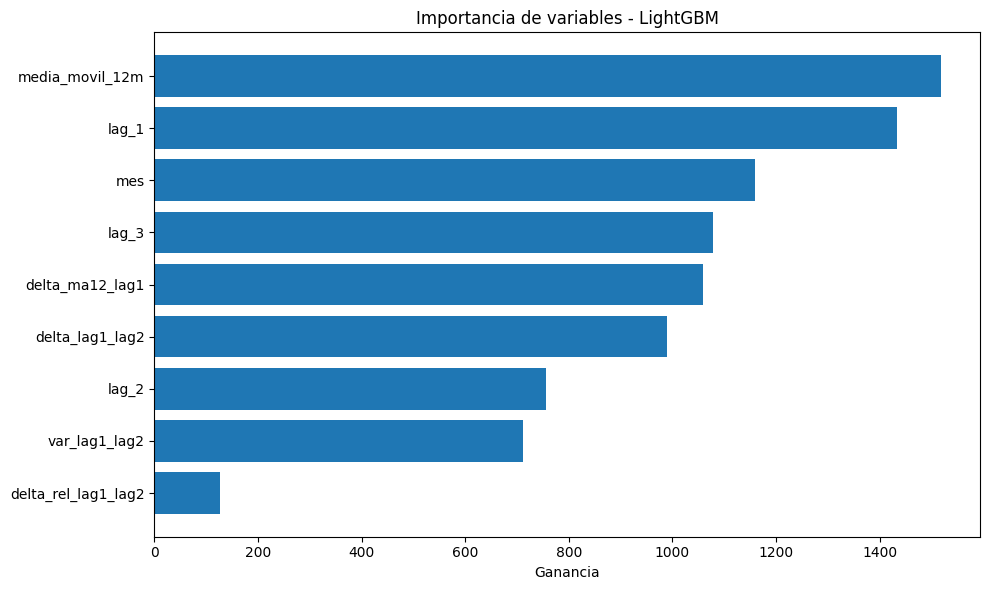

In [10]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()


In [11]:
# Comparación por producto
comparacion = feb_df[['product_id', 'tn_predicho', 'tn_predicho_ajustada', 'febrero_hist']].copy()

# Totales agregados
total_modelo = comparacion['tn_predicho'].sum()
total_ajustada = comparacion['tn_predicho_ajustada'].sum()
total_febrero_hist = comparacion['febrero_hist'].sum()

print("🔎 Comparación de totales:")
print(f"📉 Predicción solo modelo...........: {total_modelo:,.2f} tn")
print(f"⚖️  Predicción ajustada (80/20)......: {total_ajustada:,.2f} tn")
print(f"📜 Promedio histórico febreros.......: {total_febrero_hist:,.2f} tn")

# Exportar comparación por producto (opcional)
#comparacion.to_csv("comparacion_feb2020.csv", index=False)
#print("📁 Comparación por producto guardada en comparacion_feb2020.csv")


🔎 Comparación de totales:
📉 Predicción solo modelo...........: 10,216.38 tn
⚖️  Predicción ajustada (80/20)......: 10,277.74 tn
📜 Promedio histórico febreros.......: 10,523.19 tn


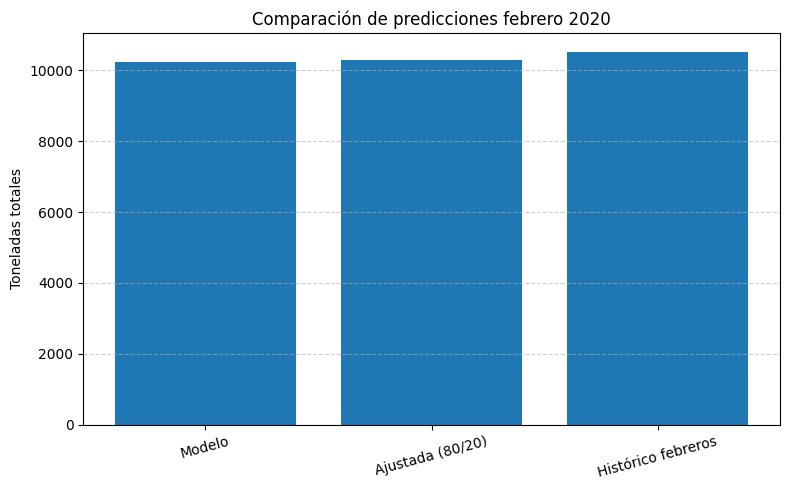

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


total_modelo = 10216.38
total_ajustada = 10277.74
total_febrero_hist = 10523.19

# Crear DataFrame para graficar
data = {
    'Tipo de predicción': ['Modelo', 'Ajustada (80/20)', 'Histórico febreros'],
    'Toneladas': [total_modelo, total_ajustada, total_febrero_hist]
}
df_plot = pd.DataFrame(data)

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(df_plot['Tipo de predicción'], df_plot['Toneladas'])
plt.ylabel('Toneladas totales')
plt.title('Comparación de predicciones febrero 2020')
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [14]:
# Crear DataFrame con valores reales y predichos para diciembre 2019
val_resultado = val_data[['product_id', 'tn']].copy()
val_resultado.rename(columns={'tn': 'tn_real'}, inplace=True)
val_resultado['tn_predicho'] = y_pred_val

# Calcular MAE por producto
mae_por_producto = val_resultado.groupby('product_id').apply(
    lambda x: mean_absolute_error(x['tn_real'], x['tn_predicho'])
).reset_index(name='mae')

# Mostrar los productos con peor desempeño
print(mae_por_producto.sort_values('mae', ascending=False).head(10))


    product_id         mae
7        20008  215.034484
2        20003  165.714145
11       20012  153.119009
17       20018  145.393439
1        20002  137.107785
13       20014  128.273474
3        20004  124.131998
10       20011   96.229378
18       20019   92.152066
12       20013   72.238427


C:\Users\waldo\AppData\Local\Temp\ipykernel_31536\2897494285.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_producto = val_resultado.groupby('product_id').apply(


In [15]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar y preparar datos
df = pd.read_csv("top_40_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 4. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 5. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 6. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 7. Preparar entrenamiento
df_train = df_lags.dropna()
features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

# 8. Entrenar modelo
mejores_params = {
    'n_estimators': 647,
    'learning_rate': 0.010595707689344216,
    'max_depth': 12,
    'num_leaves': 215,
    'subsample': 0.7554369080564807,
    'colsample_bytree': 0.8144048873939789,
    'random_state': 42,
    'min_data_in_leaf': 38,
    'reg_alpha': 1.5224038755383693,
    'reg_lambda': 2.3716401583915445,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 9. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 10. Preparar df para febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

# Usar media móvil de diciembre 2019 como proxy de lag_1
lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
lag1_df = lag1_df.rename(columns={'media_movil_12m': 'lag_1'})
feb_df = feb_df.merge(lag1_df, on='product_id', how='left')

# Agregar lag_2 y lag_3 reales
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
feb_df = feb_df.merge(lag2, on='product_id', how='left')
feb_df = feb_df.merge(lag3, on='product_id', how='left')

# Media móvil
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
feb_df = feb_df.merge(media_mov, on='product_id', how='left')

# Calcular deltas
feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Merge con histórico de febreros
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')

# 11. Predicción
feb_df['tn_predicho'] = modelo.predict(feb_df[features])
feb_df['tn_predicho_ajustada'] = 0.8 * feb_df['tn_predicho'] + 0.2 * feb_df['febrero_hist']

# 12. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']]
resultado.rename(columns={'tn_predicho_ajustada': 'tn_predicho'}, inplace=True)
resultado.to_csv("prediccion_feb2020_top40_4.csv", index=False)
print("✅ Predicción febrero 2020 guardada con lag_1 basado en media móvil en prediccion_feb2020_top40_4.csv")


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 9
[LightGBM] [Info] Start training from score 545.043467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\waldo\AppData\Local\Temp\ipykernel_31536\3512282702.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado.rename(columns={'tn_predicho_ajustada': 'tn_predicho'}, inplace=True)


In [16]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top40_4.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_40_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo            tn
1  2017-02-01  10414.562270
2  2017-03-01  14360.257460
3  2017-04-01  12495.123440
4  2017-05-01  14867.309850
5  2017-06-01  14365.538740
6  2017-07-01  13124.215230
7  2017-08-01  14592.670290
8  2017-09-01  17528.125200
9  2017-10-01  17999.233710
10 2017-11-01  14961.253380
11 2017-12-01  12500.909020
12 2018-01-01  10131.945400
13 2018-02-01  11245.160940
14 2018-03-01  14930.808840
15 2018-04-01  11746.679490
16 2018-05-01  12900.034470
17 2018-06-01  11247.895820
18 2018-07-01  11228.336050
19 2018-08-01  13380.396380
20 2018-09-01  11416.147900
21 2018-10-01  13908.308900
22 2018-11-01  12885.855050
23 2018-12-01  10159.442040
24 2019-01-01  10589.115960
25 2019-02-01   9909.840890
26 2019-03-01  11475.244060
27 2019-04-01  11667.192040
28 2019-05-01  11385.048680
29 2019-06-01  11377.759700
30 2019-07-01  11965.831900
31 2019-08-01   8142.772430
32 2019-09-01  12112.214620
33 2019-


📌 Importancia de variables:
               feature  importancia
4      media_movil_12m         1518
0                lag_1         1433
3                  mes         1159
2                lag_3         1078
8      delta_ma12_lag1         1060
6      delta_lag1_lag2          989
1                lag_2          757
5        var_lag1_lag2          712
7  delta_rel_lag1_lag2          127


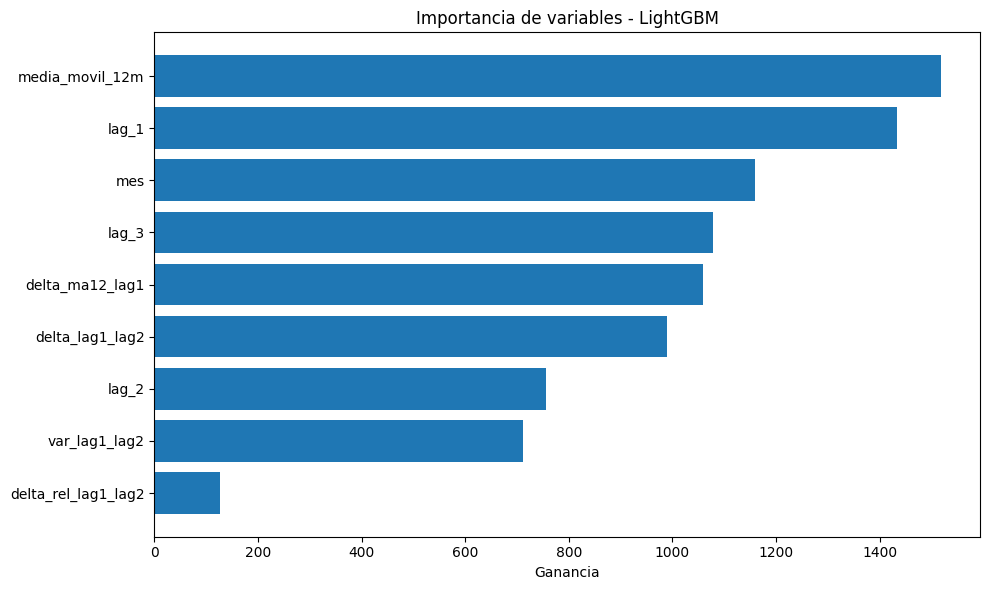

In [17]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()
